In [ ]:
!pip install contractions
!pip install html2text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 491.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 1.9 MB/s eta 0:00:00


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nltk   
import contractions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import html2text
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv
/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
inp_train = pd.read_csv("/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv")
inp_validation= pd.read_csv("/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv")

In [ ]:
inp_train.describe(include='all')

,Id,Title,Body,Tags,CreationDate,Y
count,4.500000e+04,45000,45000,45000,45000,45000
unique,NaN,44996,45000,25676,44990,3
top,NaN,Regular expression,<p>I'm already familiar with repeating tasks e...,<python>,2016-04-27 09:59:45,LQ_CLOSE
freq,NaN,3,1,798,2,15000
mean,4.575616e+07,NaN,NaN,NaN,NaN,NaN
std,7.120035e+06,NaN,NaN,NaN,NaN,NaN
min,3.455266e+07,NaN,NaN,NaN,NaN,NaN
25%,3.973593e+07,NaN,NaN,NaN,NaN,NaN
50%,4.503563e+07,NaN,NaN,NaN,NaN,NaN
75%,5.125584e+07,NaN,NaN,NaN,NaN,NaN


In [ ]:
inp_train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


<AxesSubplot:>

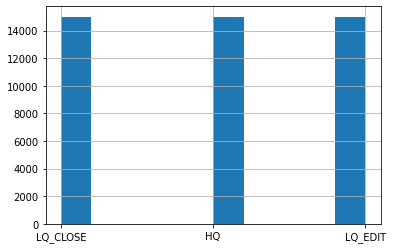

In [ ]:
inp_train['Y'].hist()

In [ ]:
inp_train['Y'].value_counts()

LQ_CLOSE    15000
HQ          15000
LQ_EDIT     15000
Name: Y, dtype: int64

## The given data is balanced based on the output. The count of all the classes in the output is equal which is 15000.

In [ ]:
inp_train['Body'][0]

'<p>I\'m already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print "Hello World" to the console every random seconds from 1-5. Unfortunately I\'m in a bit of a rush and don\'t have any code to show so far. Any help would be apriciated.  </p>\n'

In [ ]:
l={}
def check_tags(l,x):
  for i in x:
    if i in list(l.keys()):
      l[i] +=1
    else:
      l[i] = 1

inp_train['Tags'].apply(lambda x:x.split('>')).apply(lambda x: check_tags(l,x))
sorted_l = sorted(l.items(), key=lambda x: x[1], reverse=True)

No Duplicates

In [ ]:
print(len(list(l.keys())))
print(len(set(list(l.keys()))))

9337
9337


In [ ]:
top_sl = sorted_l[:40]
tags = np.asarray(top_sl)[1:][:,0]
counts = np.asarray(top_sl)[1:][:,1]
counts_rev = counts[::-1]
tags_rev = tags[::-1]
print(tags_rev)
print(counts_rev)

['<asp.net' '<xcode' '<laravel' '<vba' '<ruby' '<react-native'
 '<android-studio' '<pandas' '<list' '<.net' '<docker' '<excel' '<linux'
 '<typescript' '<json' '<string' '<sql-server' '<node.js' '<regex' '<r'
 '<reactjs' '<python-3.x' '<angular' '<swift' '<mysql' '<sql' '<ios'
 '<arrays' '<c' '<jquery' '<css' '<c++' '<html' '<php' '<c#' '<android'
 '<java' '<python' '<javascript']
['351' '354' '357' '372' '376' '383' '391' '418' '424' '433' '467' '473'
 '481' '647' '731' '733' '792' '793' '833' '862' '873' '991' '1096' '1156'
 '1166' '1243' '1339' '1367' '1383' '1410' '1594' '2263' '2562' '3125'
 '3137' '3573' '4677' '5041' '5385']


Bar plot for top 40 tags


<BarContainer object of 39 artists>

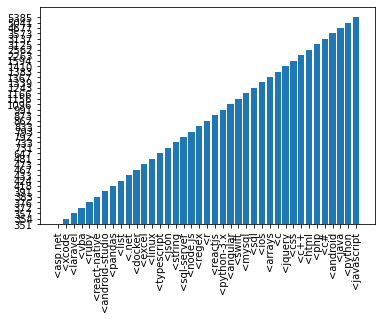

In [ ]:
plt.xticks(rotation=90)
plt.bar(tags_rev, counts_rev)

In [ ]:
inp_train['Y'].unique()

array(['LQ_CLOSE', 'HQ', 'LQ_EDIT'], dtype=object)

In [ ]:
inp_train[inp_train['Y']=='HQ']['Tags'].apply(lambda x:x.split('>')).apply(lambda x: check_tags(l,x))
sorted_l = sorted(l.items(), key=lambda x: x[1], reverse=True)

top_sl = sorted_l[:40]
tags = np.asarray(top_sl)[1:][:,0]
counts = np.asarray(top_sl)[1:][:,1]
counts_rev = counts[::-1]
tags_rev = tags[::-1]

<BarContainer object of 39 artists>

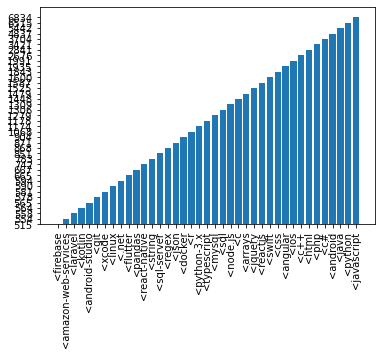

In [ ]:
plt.xticks(rotation=90)
plt.bar(tags_rev, counts_rev)

In [ ]:
inp_train[inp_train['Y']=='LQ_EDIT']['Tags'].apply(lambda x:x.split('>')).apply(lambda x: check_tags(l,x))
sorted_l = sorted(l.items(), key=lambda x: x[1], reverse=True)

top_sl = sorted_l[:40]
tags = np.asarray(top_sl)[1:][:,0]
counts = np.asarray(top_sl)[1:][:,1]
counts_rev = counts[::-1]
tags_rev = tags[::-1]

<BarContainer object of 39 artists>

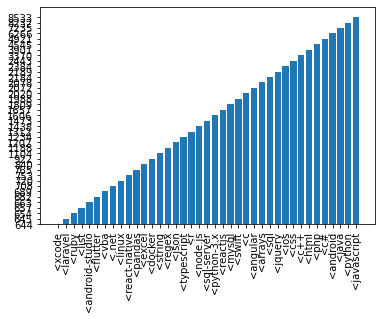

In [ ]:
plt.xticks(rotation=90)
plt.bar(tags_rev, counts_rev)

In [ ]:
inp_train[inp_train['Y']=='LQ_CLOSE']['Tags'].apply(lambda x:x.split('>')).apply(lambda x: check_tags(l,x))
sorted_l = sorted(l.items(), key=lambda x: x[1], reverse=True)

top_sl = sorted_l[:40]
tags = np.asarray(top_sl)[1:][:,0]
counts = np.asarray(top_sl)[1:][:,1]
counts_rev = counts[::-1]
tags_rev = tags[::-1]

<BarContainer object of 39 artists>

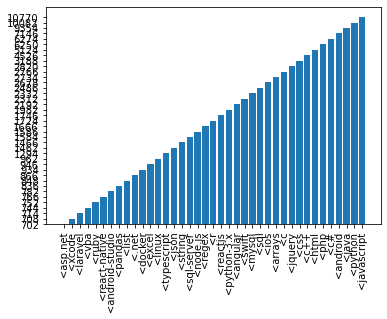

In [ ]:
plt.xticks(rotation=90)
plt.bar(tags_rev, counts_rev)

## Testing the html2text package on the body attribute of the data

In [ ]:
import html2text
print(html2text.html2text(inp_train['Body'][0]))

I'm already familiar with repeating tasks every n seconds by using
Java.util.Timer and Java.util.TimerTask. But lets say I want to print "Hello
World" to the console every random seconds from 1-5. Unfortunately I'm in a
bit of a rush and don't have any code to show so far. Any help would be
apriciated.




In [ ]:
inp_train_aug=inp_train
inp_train_aug['BodyText']=inp_train_aug.apply(lambda row: html2text.html2text(row.Body), axis = 1)
inp_train_aug['BodyText']=inp_train_aug.apply(lambda row: row.BodyText.replace("\n", " "), axis = 1)

## Creating a new attribute 'BodyText' with the inp_train_aug dataframe

In [ ]:
inp_train_aug

,Id,Title,Body,Tags,CreationDate,Y,BodyText
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,I'm already familiar with repeating tasks ever...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,I'd like to understand why Java 8 Optionals we...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,I am attempting to overlay a title over an ima...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"The question is very simple, but I just could ..."
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,I'm using custom floatingactionmenu. I need to...
...,...,...,...,...,...,...,...
44995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE,I am new to this and I am asking for help to c...
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE,I am working on learning Python and was wonder...
44997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE,It looks like it costs 8 days per month in Azu...
44998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE,"""I _____ any questions."" I want to implement ..."


## Understanding the distribution of the length of the body text

In [ ]:
inp_train_aug['len_body']=inp_train_aug.apply(lambda row: len(row.BodyText.split()), axis = 1)
inp_train_aug['len_body'].describe()


count    45000.000000
mean       107.376200
std        120.708652
min          0.000000
25%         46.000000
50%         76.000000
75%        128.000000
max       5412.000000
Name: len_body, dtype: float64

# Plotting all the length

<AxesSubplot:>

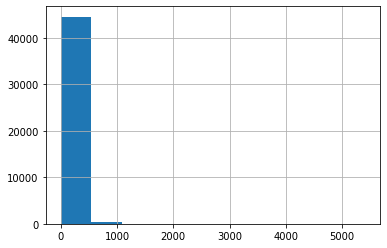

In [ ]:
inp_train_aug['len_body'].hist()

# Plotting next 100 rows in the descending order

<AxesSubplot:>

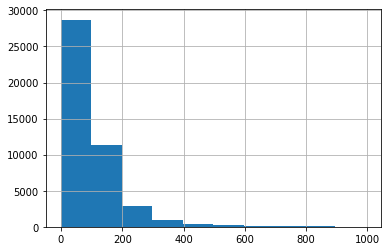

In [ ]:
inp_train_aug.sort_values(by = 'len_body', ascending = False)['len_body'][100:].hist()

In [ ]:
inp_train_aug.sort_values(by = 'len_body', ascending = False)[0:15]

,Id,Title,Body,Tags,CreationDate,Y,BodyText,len_body
39738,55632261,"How to pair sublists of (x,y) cell coordinates?",I have a list of 60 lists (representing 60 ima...,<python><list><data-structures><nested><distance>,2019-04-11 12:14:47,LQ_EDIT,I have a list of 60 lists (representing 60 ima...,5412
37575,53926858,i cant import a database from sql server to ph...,consulta SQL: Documentación\r\nUSE [master] GO...,<mysql><sql><phpmyadmin><xampp>,2018-12-26 02:21:58,LQ_EDIT,consulta SQL: Documentación USE [master] GO CR...,3274
12345,40190847,How do i remove all numbers in python script *...,# Help all numbers in this list need to be rem...,<python>,2016-10-22 10:07:35,LQ_EDIT,# Help all numbers in this list need to be rem...,3076
40325,56102929,Need to expand an inventory journal (log) pand...,<p>I have an inventory journal that contains p...,<python><pandas><performance><inventory-manage...,2019-05-12 19:53:12,HQ,I have an inventory journal that contains prod...,3010
16794,42137223,Moving values in a column to a specific row.,I have datasett in my bachelor thesis.\r\nThis...,<r><rows>,2017-02-09 12:50:51,LQ_EDIT,I have datasett in my bachelor thesis. This is...,2924
42245,57731810,Datasets not joining,<p>I'm having trouble joining FBI crime data w...,<r><join>,2019-08-30 18:43:21,LQ_CLOSE,I'm having trouble joining FBI crime data with...,2789
20520,44003131,HTML To PDF conversion of invoice,<p><strong>I want to convert this HTML invoice...,<c#><html><asp.net><.net><asp.net-mvc>,2017-05-16 13:38:49,LQ_CLOSE,**I want to convert this HTML invoice to PDF i...,2423
26707,47723882,Need help fixing my c++ fighting game with Run...,I have been receiving an issue that I do not u...,<c++>,2017-12-09 00:05:15,LQ_EDIT,I have been receiving an issue that I do not u...,2209
22204,44849586,"How to color active, wrong and correct words i...",\r\n\r\n<!-- begin snippet: js hide: false con...,<javascript>,2017-06-30 15:07:12,LQ_EDIT,var hasStarted = false; //strToTest is an arra...,2204
15251,41416896,Need Help ! How to add a custom font this acti...,\r\n\r\n> Hello Evrybody\r\ni hope u are f...,<android><fonts>,2017-01-01 16:15:55,LQ_EDIT,> Hello Evrybody i hope u are fine:) first wor...,2133


In [ ]:
inp_train_aug.to_csv('old_selected_train.csv',columns=['Title','Body','BodyText','Y'],index=False)

In [ ]:
inp_validation_aug=inp_validation
inp_validation_aug['BodyText']=inp_validation_aug.apply(lambda row: html2text.html2text(row.Body), axis = 1)
inp_validation_aug['BodyText']=inp_validation_aug.apply(lambda row: row.BodyText.replace("\n", " "), axis = 1)
inp_validation_aug.to_csv('old_selected_validation.csv',columns=['BodyText','Y'],index=False)

# Creating alternate replacement strategy

Creating new train dataset

In [ ]:
inp_train_aug2=inp_train

In [ ]:
def repls(row):
    cont_replace = [] 
    for word in row.strip().split():
#         print(word)
        cont_replace.append(contractions.fix(word))
#     print(cont_replace)
    cont_replace=" ".join(cont_replace)
    stopword = set(stopwords.words('english'))
    tokenword = word_tokenize(cont_replace)
    cont_replace=[word_test for word_test in tokenword if not word_test.lower() in stopword]
    cont_replace=" ".join(cont_replace)
    return cont_replace

In [ ]:
reg_replace={'\\n':' ',r'\W':' ',r'http\s+|www.\s+':r'',r'https\s+|www.\s+':r'',
             r'\s+[a-zA-Z]\s+':' ',r'\^[a-zA-Z]\s+':' ',r'\s+':' ',r"\’":"\'",r"\r":"",r"\n":"",r"[0-9]":"num",
            r'[.|,|)|(|\|/]':r' '}
inp_train_aug2['Merged']=inp_train['Title']+" "+inp_train['Body']
inp_train_aug2['Merged']=inp_train_aug2['Merged'].str.lower()
for k,v in reg_replace.items():
    inp_train_aug2['Merged']=inp_train_aug2['Merged'].map(lambda row: re.sub(k,v,str(row)))
    print(k,"on row:",inp_train_aug2['Merged'][0])

\n on row: java: repeat task every random seconds <p>i'm already familiar with repeating tasks every n seconds by using java.util.timer and java.util.timertask. but lets say i want to print "hello world" to the console every random seconds from 1-5. unfortunately i'm in a bit of a rush and don't have any code to show so far. any help would be apriciated.  </p>
\W on row: java  repeat task every random seconds  p i m already familiar with repeating tasks every n seconds by using java util timer and java util timertask  but lets say i want to print  hello world  to the console every random seconds from 1 5  unfortunately i m in a bit of a rush and don t have any code to show so far  any help would be apriciated     p 
http\s+|www.\s+ on row: java  repeat task every random seconds  p i m already familiar with repeating tasks every n seconds by using java util timer and java util timertask  but lets say i want to print  hello world  to the console every random seconds from 1 5  unfortunate

In [ ]:
rw=inp_train_aug2['Merged'][0]
rw
repls(rw)

'java repeat task every random seconds already familiar repeating tasks every seconds using java util timer java util timertask let us say want print hello world console every random seconds num num unfortunately bit rush code show far help would apriciated'

In [ ]:
inp_train_aug2['Merged'][0]

'java repeat task every random seconds i already familiar with repeating tasks every seconds by using java util timer and java util timertask but lets say want to print hello world to the console every random seconds from num num unfortunately m in bit of rush and don have any code to show so far any help would be apriciated '

In [ ]:

reg_repl2= {"\'":"",r"\"":"",r'[?|!|\'|"|#]':r''}
inp_train_aug2['Merged']=inp_train_aug2.apply(lambda row: repls(row.Merged), axis = 1)
for k,v in reg_repl2.items():
    inp_train_aug2['Merged']=inp_train_aug2['Merged'].map(lambda row: re.sub(k,v,str(row)))

In [ ]:
inp_train_aug2['Merged'][0]

'java repeat task every random seconds already familiar repeating tasks every seconds using java util timer java util timertask let us say want print hello world console every random seconds num num unfortunately bit rush code show far help would apriciated'

In [ ]:
inp_train_aug2.to_csv('allop_train.csv',columns=['Merged','Y'],index=False)

Creating new test Dataset

In [ ]:
inp_val_2=inp_validation

In [ ]:
inp_val_2=inp_validation
reg_replace={'\\n':' ',r'\W':' ',r'http\s+|www.\s+':r'',r'https\s+|www.\s+':r'',
             r'\s+[a-zA-Z]\s+':' ',r'\^[a-zA-Z]\s+':' ',r'\s+':' ',r"\’":"\'",r"\r":"",r"\n":"",r"[0-9]":"num",
            r'[.|,|)|(|\|/]':r' '}
inp_val_2['Merged']=inp_val_2['Title']+" "+inp_val_2['Body']
inp_val_2['Merged']=inp_val_2['Merged'].str.lower()
for k,v in reg_replace.items():
    inp_val_2['Merged']=inp_val_2['Merged'].map(lambda row: re.sub(k,v,str(row)))
reg_repl2= {"\'":"",r"\"":"",r'[?|!|\'|"|#]':r''}
inp_val_2['Merged']=inp_val_2.apply(lambda row: repls(row.Merged), axis = 1)
for k,v in reg_repl2.items():
    inp_val_2['Merged']=inp_val_2['Merged'].map(lambda row: re.sub(k,v,str(row)))


In [ ]:
inp_val_2.to_csv('allop_val.csv',columns=['Merged','Y'],index=False)